In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from io import StringIO
import requests

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
from tsad.evaluating.evaluating import evaluating

# Data loading

In [4]:
def dataframe_expirement(i):
    if i == 1:
        url = "https://storage.yandexcloud.net/cloud-files-public/dataframe.csv" 
        dataframe = pd.read_csv(StringIO(requests.get(url).content.decode('utf-8')), sep='|')
        dataframe_columns = dataframe.columns 
        first_label_list = dataframe[dataframe_columns[0]].unique() 
        dataframe_aa564g = dataframe[dataframe[dataframe_columns[0]] == first_label_list[0]]
        dataframe_aa564g_first = dataframe_aa564g.drop(axis=1, labels=(dataframe_aa564g.columns[0])) \
            .drop(axis=1, labels=(dataframe_aa564g.columns[1]))[['m', 'v/v', 'v/v.1',
                                                                 'uR/h', 'ohmm', 'ohmm.1', 'ohmm.2', 'ohmm.3', 'ohmm.5',
                                                                 'ohmm.6',
                                                                 'unitless', 'unitless.1']].reset_index(drop=True)
        dataframe_edited_ = dataframe_aa564g_first.loc[dataframe_aa564g_first['unitless.1'] >= 0] \
            .loc[dataframe_aa564g_first['unitless'] >= 0].loc[dataframe_aa564g_first['ohmm'] >= 0] \
            .loc[dataframe_aa564g_first['ohmm.1'] >= 0].loc[dataframe_aa564g_first['ohmm.2'] >= 0] \
            .loc[dataframe_aa564g_first['ohmm.3'] >= 0].loc[dataframe_aa564g_first['ohmm.5'] >= 0] \
            .loc[dataframe_aa564g_first['ohmm.6'] >= 0].loc[dataframe_aa564g_first['uR/h'] >= 0] \
            .loc[dataframe_aa564g_first['v/v.1'] >= 0].loc[dataframe_aa564g_first['v/v'] >= 0] \
            .reset_index(drop=True)
    else:
        url = "https://storage.yandexcloud.net/cloud-files-public/noname_ECG_2022.csv" 
        dataframe_edited_ = pd.read_csv(StringIO(requests.get(url).content.decode('utf-8')), sep=',')
    return dataframe_edited_

In [5]:
ts_data_1 = dataframe_expirement(1)
time_series_test = ts_data_1['uR/h']

# Data Description

In [6]:
# dataset characteristics printing
print(f'A number of datasets: {1}\n')
print(f'Shape of the well dataset: {ts_data_1.shape}\n')
print(f'Head of the well dataset:')
display(ts_data_1.head())
print(f'INFO of the well dataset:')
display(ts_data_1.info())

A number of datasets: 1

Shape of the well dataset: (8754, 12)

Head of the well dataset:


,m,v/v,v/v.1,uR/h,ohmm,ohmm.1,ohmm.2,ohmm.3,ohmm.5,ohmm.6,unitless,unitless.1
0,3185.5,0.960549,0.901756,56.50,38.11802,46.61687,26.52874,36.00038,0.126035,0.126063,5,1
1,3185.6,0.960549,0.924199,55.10,38.51000,41.08000,28.23000,30.61000,0.126035,0.126062,5,1
2,3185.7,0.960549,0.920993,55.30,38.49500,40.22613,27.25827,29.11342,0.126035,0.126062,5,1
3,3185.8,0.960549,0.917787,55.50,38.48000,39.39000,26.32000,27.69000,0.126035,0.126062,5,1
4,3185.9,0.960549,0.922435,55.21,37.06394,38.07816,28.97599,30.48858,0.126035,0.126061,5,1


INFO of the well dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8754 entries, 0 to 8753
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   m           8754 non-null   float64
 1   v/v         8754 non-null   float64
 2   v/v.1       8754 non-null   float64
 3   uR/h        8754 non-null   float64
 4   ohmm        8754 non-null   float64
 5   ohmm.1      8754 non-null   float64
 6   ohmm.2      8754 non-null   float64
 7   ohmm.3      8754 non-null   float64
 8   ohmm.5      8754 non-null   float64
 9   ohmm.6      8754 non-null   float64
 10  unitless    8754 non-null   int64  
 11  unitless.1  8754 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 820.8 KB


None

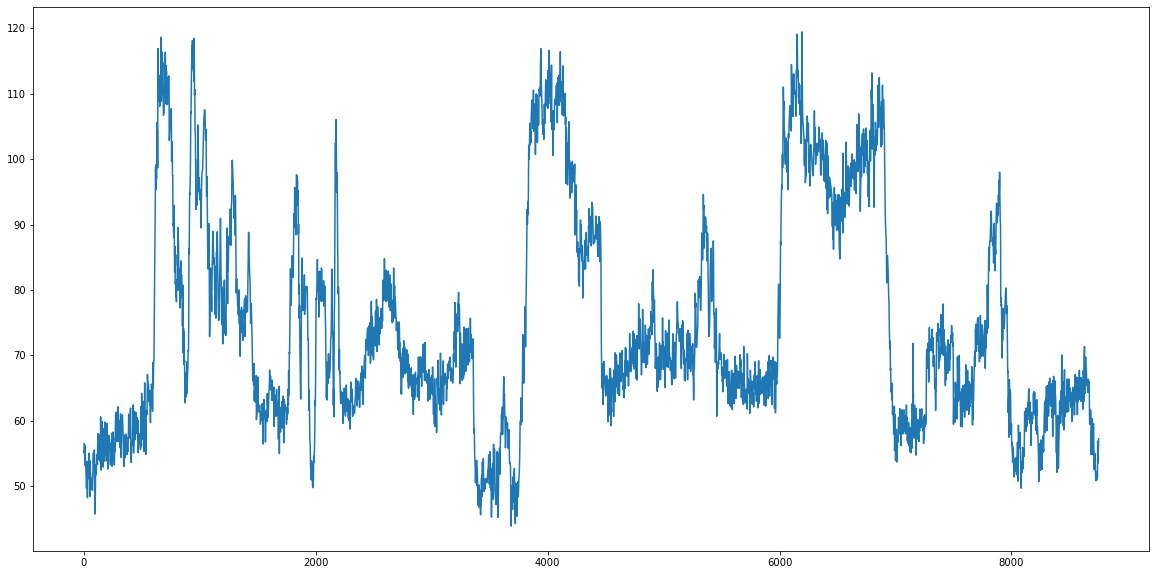

In [7]:
plt.plot(time_series_test)

# Method applying

In [8]:
import numpy as np
from itertools import chain # list of list to one bit list

In [9]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

In [10]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

def list_measured_function(window_size, ts):
    list_measured_pos = []
    for i in range(0, len(ts), window_size):
        temp = list(ts[i:i+window_size])
        mean_ts, var_ts = np.mean(temp), np.var(temp)
        list_measured_pos.append(gaussian(mean_ts, var_ts))
    return list_measured_pos

def make_one_step_prediction(list_measured_pos, g=gaussian(100, .1800**2), window=10):
    list_prediction, predictions_x = [], []
    for i in range(1,len(list_measured_pos)):
        prior = predict(list_measured_pos[i-1], g)
        likelihood = list_measured_pos[i-1]
        x = update(prior, likelihood)
        predictions_x.append(np.random.normal(loc=x.mean, scale=x.var, size=window))
        list_prediction.append(x)
    print()
    print('final estimate:        {:10.3f}'.format(list_prediction[-1].mean))
    print('actual final position: {:10.3f}'.format(list_measured_pos[-1].mean))
    return list_prediction, predictions_x

In [11]:
window_size = 10

In [12]:
list_measured_pos = list_measured_function(window_size= window_size, ts = time_series_test)

In [13]:
list_prediction, list_x_mean = make_one_step_prediction(list_measured_pos, g=gaussian(1, .18**2), window = window_size)


final estimate:            54.318
actual final position:     56.383


In [14]:
new_list = list(map(int, chain.from_iterable(list_x_mean)))

# Metrics calculation

In [15]:
def mae_mse_rmse(true_label, predicted_label):
    mae = sum([abs(true_label[i] - predicted_label[i]) for i in range(len(predicted_label))])/len(predicted_label)
    mse = sum([(true_label[i] - predicted_label[i])**2 for i in range(len(predicted_label))])/len(predicted_label)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

In [16]:
mae, mse, rmse = mae_mse_rmse(time_series_test, new_list)

In [17]:
print(f'window size for prediction: {window_size}')
print()
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

window size for prediction: 10

MAE: 2.108022874285717
MSE: 14.200807016974109
RMSE: 3.7683958147962784


# Results

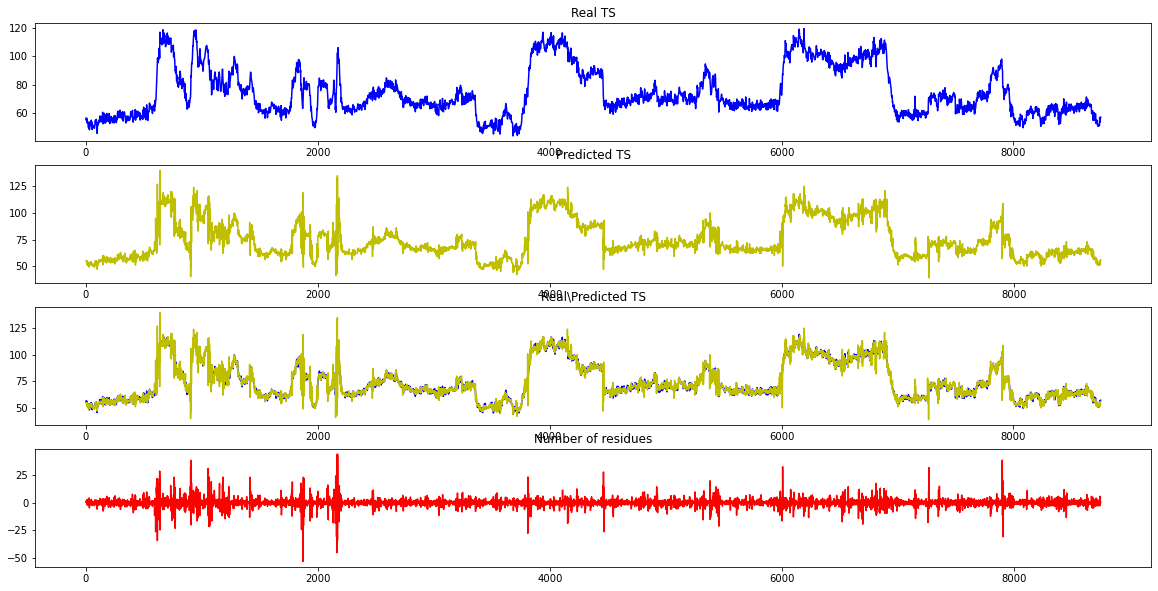

In [18]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 1)
  
axis[0].plot(time_series_test,color='b')
axis[0].set_title("Real TS")
  
axis[1].plot(new_list, color='y')
axis[1].set_title("Predicted TS")
  
# For Tangent Function
axis[2].plot(time_series_test, color='b', label='Real TS')
axis[2].plot(new_list, color='y', label='Predicted TS')
axis[2].set_title("Real\Predicted TS")
  
# For Tanh Function
axis[3].plot(time_series_test[:len(new_list)] - new_list, color='r')
axis[3].set_title("Number of residues")

plt.show()

# Change Point Prediction based on residues 

In [19]:
true_cp = []
temp_value_second = 0
for i in range(len(ts_data_1)):
    temp_value = ts_data_1['unitless'][i]
    if temp_value != temp_value_second:
        true_cp.append(1)
    else:
        true_cp.append(0)
    temp_value_second = temp_value
true_cp[0] = 0

In [20]:
residues_list = time_series_test[:len(new_list)] - new_list

In [21]:
std_3 = residues_list.std()*3

In [22]:
predicted_cp = []
for i in residues_list:
    if i > std_3:
        predicted_cp.append(1)
    else:
        predicted_cp.append(0)

In [23]:
t_0 = np.arange(len(true_cp)).astype('datetime64[s]')

In [24]:
df_0 = pd.DataFrame(index=t_0, columns=['predicted_cp'])
df_0['predicted_cp'] = np.array(predicted_cp + [0,0,0,0])
df_0['true_change_points'] = np.array(true_cp)

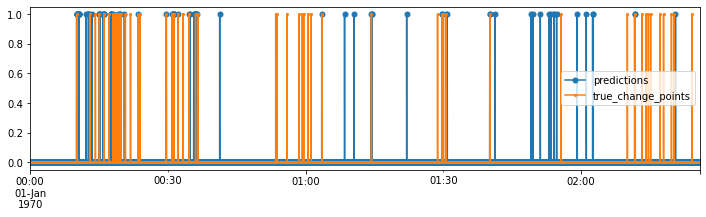

In [25]:
# true changepoint indices selection

df_0.predicted_cp.plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
df_0.true_change_points.plot(marker='o', markersize=2)
plt.legend();

In [26]:
# nab metric calculation
nab = evaluating(df_0['true_change_points'], df_0['predicted_cp'], metric='nab', numenta_time='30 sec')

Intersection of scoring windows(Timestamp('1970-01-01 00:18:00'), Timestamp('1970-01-01 00:17:54'))
Intersection of scoring windows(Timestamp('1970-01-01 00:18:24'), Timestamp('1970-01-01 00:18:16'))
Intersection of scoring windows(Timestamp('1970-01-01 00:18:46'), Timestamp('1970-01-01 00:18:31'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:01'), Timestamp('1970-01-01 00:18:45'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:15'), Timestamp('1970-01-01 00:19:01'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:31'), Timestamp('1970-01-01 00:19:13'))
Intersection of scoring windows(Timestamp('1970-01-01 00:23:33'), Timestamp('1970-01-01 00:23:25'))
Intersection of scoring windows(Timestamp('1970-01-01 00:30:52'), Timestamp('1970-01-01 00:30:47'))
Intersection of scoring windows(Timestamp('1970-01-01 00:36:01'), Timestamp('1970-01-01 00:36:01'))
Intersection of scoring windows(Timestamp('1970-01-01 00:53:29'), Timestamp('1970-01-01 00:53:17'))


In [27]:
# average detection delay metric calculation
add = evaluating(df_0['true_change_points'], df_0['predicted_cp'], metric='average_time', numenta_time='30 sec')

Intersection of scoring windows(Timestamp('1970-01-01 00:18:00'), Timestamp('1970-01-01 00:17:54'))
Intersection of scoring windows(Timestamp('1970-01-01 00:18:24'), Timestamp('1970-01-01 00:18:16'))
Intersection of scoring windows(Timestamp('1970-01-01 00:18:46'), Timestamp('1970-01-01 00:18:31'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:01'), Timestamp('1970-01-01 00:18:45'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:15'), Timestamp('1970-01-01 00:19:01'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:31'), Timestamp('1970-01-01 00:19:13'))
Intersection of scoring windows(Timestamp('1970-01-01 00:23:33'), Timestamp('1970-01-01 00:23:25'))
Intersection of scoring windows(Timestamp('1970-01-01 00:30:52'), Timestamp('1970-01-01 00:30:47'))
Intersection of scoring windows(Timestamp('1970-01-01 00:36:01'), Timestamp('1970-01-01 00:36:01'))
Intersection of scoring windows(Timestamp('1970-01-01 00:53:29'), Timestamp('1970-01-01 00:53:17'))


# Take a look at connections between window_size and RMSE, MAE, MSE

In [28]:
mae_list, mse_list, rmse_list = [], [], []
for i in range(1,500):
    window_size = i
    list_measured_pos = list_measured_function(window_size= window_size, ts = time_series_test)
    list_prediction, list_x_mean = make_one_step_prediction(list_measured_pos, g=gaussian(1, .18**2), window = window_size)
    new_list = list(map(int, chain.from_iterable(list_x_mean)))
    mae, mse, rmse = mae_mse_rmse(time_series_test, new_list)
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)


final estimate:            56.450
actual final position:     57.220

final estimate:            56.327
actual final position:     56.835

final estimate:            56.466
actual final position:     56.450

final estimate:            56.385
actual final position:     56.835

final estimate:            55.951
actual final position:     56.383

final estimate:            54.266
actual final position:     56.217

final estimate:            55.160
actual final position:     56.383

final estimate:            55.894
actual final position:     56.835

final estimate:            53.552
actual final position:     56.217

final estimate:            54.318
actual final position:     56.383

final estimate:            52.038
actual final position:     55.868

final estimate:            53.043
actual final position:     56.217

final estimate:            53.239
actual final position:     56.442

final estimate:            53.520
actual final position:     56.383

final estimate:            52.049

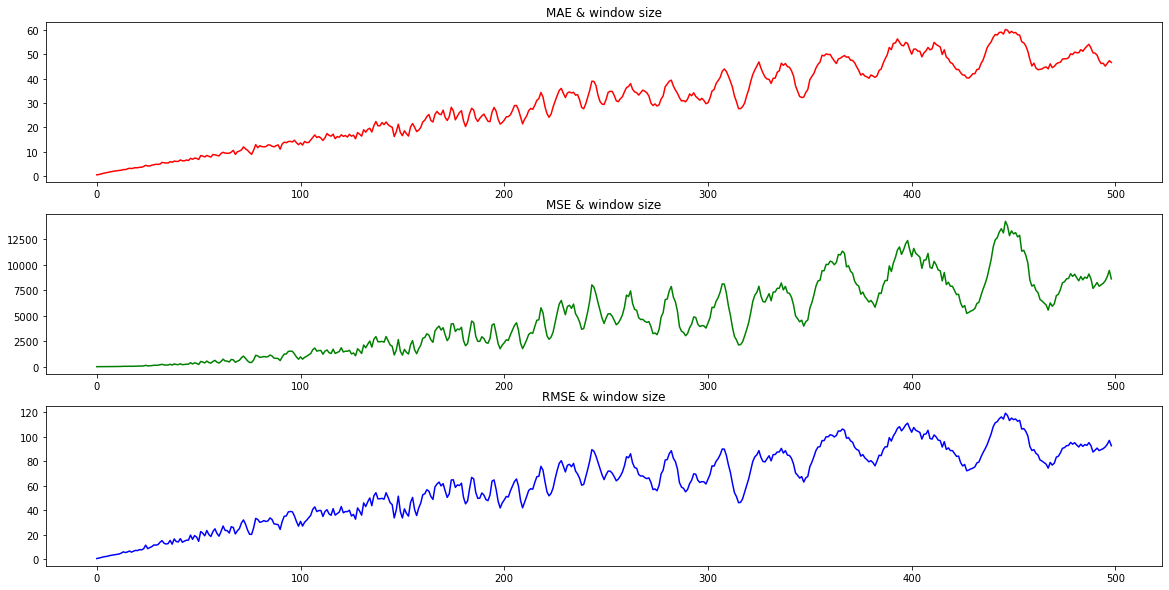

In [29]:
figure, axis = plt.subplots(3, 1)
  
axis[0].plot(mae_list,color='r')
axis[0].set_title("MAE & window size")
  
axis[1].plot(mse_list, color='g')
axis[1].set_title("MSE & window size")
  
# For Tangent Function
axis[2].plot(rmse_list, color='b', label='Real TS')
axis[2].set_title("RMSE & window size")

plt.show()